In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import optuna
import shap
import joblib


In [2]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/parkinson/train.csv")
test_df = pd.read_csv("/kaggle/input/parkinson/test.csv")
val_df = pd.read_csv("/kaggle/input/parkinson/val.csv")

# Define features and target
target_col = "motor_UPDRS"
target_and_related = ["motor_UPDRS", "subject#", "total_UPDRS"]

# Split datasets
X_train = train_df.drop(columns=target_and_related)
y_train = train_df[target_col]

X_test = test_df.drop(columns=target_and_related)
y_test = test_df[target_col]

X_val = val_df.drop(columns=target_and_related)
y_val = val_df[target_col]

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


In [3]:
from sklearn.metrics import mean_squared_error

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

y_bins = pd.qcut(y_train, q=10, labels=False)  # Create bins for stratification

rmse_scores = []  # Store RMSE for each fold

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_bins)):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_fold, y_train_fold)

    y_val_pred = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))  # Calculate RMSE
    rmse_scores.append(rmse)

    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

# Print Mean RMSE Across Folds
mean_rmse = np.mean(rmse_scores)
print(f"\nMean RMSE Across {n_splits} Folds: {mean_rmse:.4f}")


Fold 1 RMSE: 4.0117
Fold 2 RMSE: 4.1631
Fold 3 RMSE: 3.9797
Fold 4 RMSE: 4.1195
Fold 5 RMSE: 3.8665

Mean RMSE Across 5 Folds: 4.0281


In [4]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)  # Updated
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    score = model.score(X_val_scaled, y_val)  # R^2 Score
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2025-02-22 14:25:43,217] A new study created in memory with name: no-name-67f528b3-39b0-4ad6-a5f5-899be6bbb8fa
[I 2025-02-22 14:26:01,234] Trial 0 finished with value: 0.951784009135208 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.02082397412476649, 'min_samples_split': 7}. Best is trial 0 with value: 0.951784009135208.
[I 2025-02-22 14:26:32,055] Trial 1 finished with value: 0.9727454893598324 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.015583869183051617, 'min_samples_split': 9}. Best is trial 1 with value: 0.9727454893598324.
[I 2025-02-22 14:26:38,681] Trial 2 finished with value: 0.8614631552278129 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.01750925279218559, 'min_samples_split': 10}. Best is trial 1 with value: 0.9727454893598324.
[I 2025-02-22 14:26:43,829] Trial 3 finished with value: 0.9699884304835779 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1805089607498

Best Hyperparameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.03870840948815698, 'min_samples_split': 5}


In [5]:
best_model = GradientBoostingRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

best_model.fit(X_train_scaled, y_train)


GradientBoostingRegressor(learning_rate=0.03870840948815698, max_depth=9,
                          min_samples_split=5, n_estimators=400,
                          random_state=42)

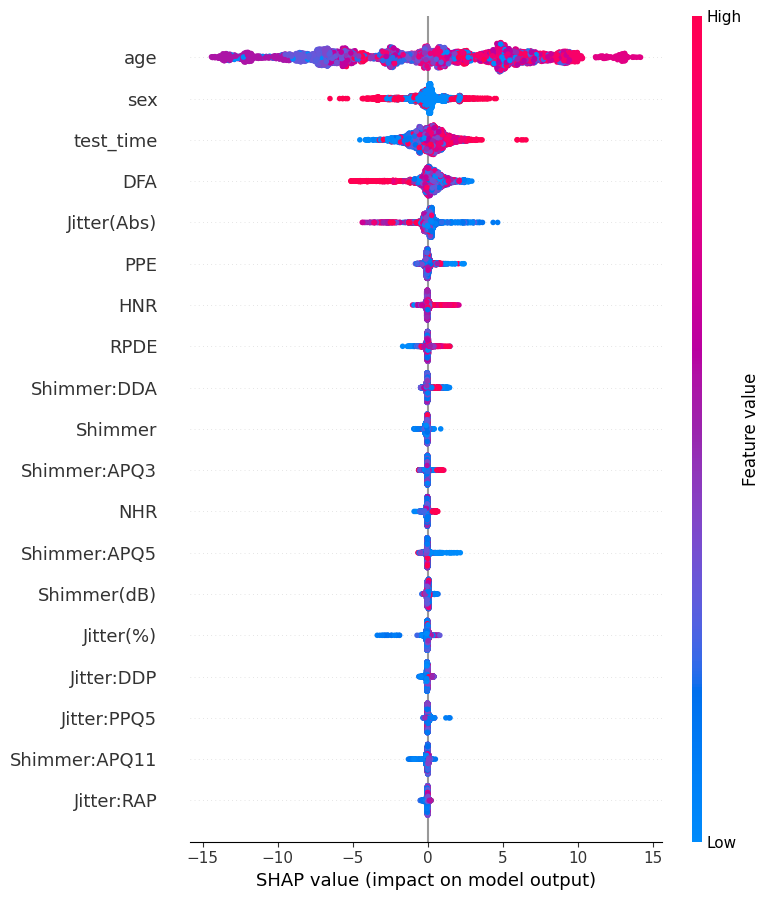

In [6]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_test_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))  # RMSE
final_mae = mean_absolute_error(y_test, y_test_pred)  # MAE
final_r2 = r2_score(y_test, y_test_pred)  # R² Score

# Print results
print(f"\nFinal Test RMSE: {final_rmse:.4f}")
print(f"Final Test MAE: {final_mae:.4f}")
print(f"Final Test R² Score: {final_r2:.4f}")



Final Test RMSE: 1.2758
Final Test MAE: 0.5855
Final Test R² Score: 0.9755


In [8]:
joblib.dump(best_model, "/kaggle/working/best_gbdt_model.pkl")
joblib.dump(scaler, "/kaggle/working/scaler.pkl")


['/kaggle/working/scaler.pkl']